<a href="https://colab.research.google.com/github/lake-thomas/spurge-temporal-cnn/blob/main/Temporal_CNN_Leafy_Spurge_June_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction May 2022
This is a working Python notebook to implement Google Earth Engine <> TensorFlow for mapping invasive plant species from a time-series of Landsat imagery. In this example, the inputs are invasive species occurrence records from public databases. The model uses 1D-Conv layers in a temporal CNN framework.

In [ ]:
# Cloud Authentication 
# Required When Using Default Google Cloud (i.e. Not Using a Hosted VM Runtime Environment)

#Connect to hosted VM https://console.cloud.google.com/marketplace/product/colab-marketplace-image-public/colab?project=pacific-engine-346519

from google.colab import auth
auth.authenticate_user()

Authenticate Earth Engine

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=H_aPP75r-fb3dkupYQBZWiKn7tWmJ1F6Au-Z3EPbZtY&tc=PIVx9D0Xj48D6BnTL87I909ynCesdytJUN8ocpuOxS8&cc=eP7dr-llVmwWYcZiNI_eLTdY_IItERcypV8k3ziW5zo

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWglxS4sNgKCOEFdk-xrhC3L2-5eJRjoUn7u3xCs7DPYxBXGqc81k8Y

Successfully saved authorization token.


Mount google drive and google cloud storage drives

In [ ]:
#Mount Google Drive for CSV reading
from google.colab import drive
drive.mount('/content/drive')

#Used to export to google cloud
from google.cloud import storage


Mounted at /content/drive


Install packages not available on Colab

In [ ]:
#Ignore Warnings and Errors
!pip install geemap
import geemap #advanced python function for GEE
!pip install geopandas
import geopandas #Pandas library to handle geospatial data
!pip install fsspec
import fsspec # file system specification
!pip install gcsfs
import gcsfs #google cloud file system

Load other packages 

In [ ]:
import os
from os.path import dirname, basename, isfile, join
import io
import glob
import pandas as pd
import numpy as np
import datetime
import pprint
import time
import math
import random
import itertools
import csv
from functools import reduce
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# Import temporalCNN python files for Temporal CNN Deep Learning analyses
# https://github.com/charlotte-pel/temporalCNN/

import sys

# Import from ~/sits folder
# Contains readingsits.py file to read and compute spectral features on SITS
sys.path.append("/content/drive/MyDrive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/sits")
import readingsits

# Import from ~/deeplearning folder
# Contains multiple .py files with varying DL architectures 
sys.path.append("/content/drive/MyDrive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/deeplearning")

import architecture_features
import architecture_complexity
import architecture_rnn
import architecture_regul
import architecture_batchsize
import architecture_depth
import architecture_spectro_temporal
import architecture_pooling

# Import from ~/outputfiles folder
# Contains evaluation.py and save.py files with fucntions to compute summary statistics, write predictions, and create confusion matrices
sys.path.append("/content/drive/MyDrive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/outputfiles")

import evaluation
import save


Import tensorflow

In [ ]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

# Keras setup.
import keras
from keras import layers
from keras.layers import Flatten
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.regularizers import l2
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Lambda, SpatialDropout1D, Concatenate
from keras.layers import Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K


2.8.0


#Get names of .csv files from Google Cloud and format training data into Pandas DF

Function takes data exported from notebook "Temporal CNN Leafy Spurge Demo April 2022.ipynb", which contains script to extract Landsat time series data on NLDC labelled points.

Reading data solution from: https://stackoverflow.com/questions/56823082/reading-all-csv-files-from-a-google-storage-bucket-into-one-large-pandas-df-th

In [ ]:

# Define google bucket hosting the .csv files for training
outputBucket = 'landcover_samples_nlcd2019_onemillionpoints'

# Make sure the bucket exists.
print('Found Cloud Storage bucket.' if tf.io.gfile.exists('gs://' + outputBucket) 
  else 'Output Cloud Storage bucket does not exist.')

storage_client = storage.Client()

source_bucket = storage_client.bucket(outputBucket)

#Select column names from landsat csv exported data frames, drop excess bands (QA, system:index, class_x_x, etc)
col_names = ["BlueMarchApril2018","GreenMarchApril2018","NDVIMarchApril2018","NIRMarchApril2018","RedMarchApril2018","SWIR1MarchApril2018","SWIR2MarchApril2018",
             "BlueMayJune2018","GreenMayJune2018","NDVIMayJune2018","NIRMayJune2018","RedMayJune2018","SWIR1MayJune2018","SWIR2MayJune2018",
             "BlueJulyAug2018","GreenJulyAug2018","NDVIJulyAug2018","NIRJulyAug2018","RedJulyAug2018","SWIR1JulyAug2018","SWIR2JulyAug2018",
             "BlueMarchApril2019","GreenMarchApril2019","NDVIMarchApril2019","NIRMarchApril2019","RedMarchApril2019","SWIR1MarchApril2019","SWIR2MarchApril2019",
             "BlueMayJune2019","GreenMayJune2019","NDVIMayJune2019","NIRMayJune2019","RedMayJune2019","SWIR1MayJune2019","SWIR2MayJune2019",
             "BlueJulyAug2019","GreenJulyAug2019","NDVIJulyAug2019","NIRJulyAug2019","RedJulyAug2019","SWIR1JulyAug2019","SWIR2JulyAug2019",
             "BlueMarchApril2020","GreenMarchApril2020","NDVIMarchApril2020","NIRMarchApril2020","RedMarchApril2020","SWIR1MarchApril2020","SWIR2MarchApril2020",
             "BlueMayJune2020","GreenMayJune2020","NDVIMayJune2020","NIRMayJune2020","RedMayJune2020","SWIR1MayJune2020","SWIR2MayJune2020",
             "BlueJulyAug2020","GreenJulyAug2020","NDVIJulyAug2020","NIRJulyAug2020","RedJulyAug2020","SWIR1JulyAug2020","SWIR2JulyAug2020","class"]

df = pd.DataFrame()

#Read in all data frames, append each to make one large dataframe
for file in list(source_bucket.list_blobs()):
    file_path="gs://{}/{}".format(file.bucket.name, file.name)
    df = df.append(pd.read_csv(file_path, header='infer'))


#Subset column names to only imagery bands (9 dates * 7 bands = 63 columns + 1 column class index)
df_imagery_class = df[col_names]

#Move last column (class ID) to first index
cls_column = df_imagery_class.pop("class")
df_imagery_class.insert(0, "class", cls_column)

#Number of class instances in the dataset
df_imagery_class['class'].value_counts()

#remove first column index
df_imagery_class.set_index('class', inplace=True)

#add column in second position as an index
df_imagery_class.insert(0, "index", range(1, 1 + len(df_imagery_class)))

#Number of rows/columns in dataset
df_imagery_class.shape

#Write full dataframe to CSV
#Export format as rows [classID, index, band_values/timeseries...] with no header
#df_imagery_class.to_csv("/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/example/full_dataset.csv", header=False)





#Divide full dataset into training and testing subsets, export to csv

Use Scikit Learn train test split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_imagery_class, test_size=0.1)

#Number of rows/columns in dataset
print(train_df.shape, test_df.shape)

#Write full dataframe to CSV
#Export format as rows [classID, index, band_values/timeseries...] with no header
train_df.to_csv("/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/example/train_dataset_2019_full_may2022.csv", header=False)
test_df.to_csv("/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/example/test_dataset_2019_full_may2022.csv", header=False)


#Ask how the training/testing dataset divided classes (how many samples/class)
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

#Number of class instances in the training and testing dataset
train_df['class'].value_counts()
test_df['class'].value_counts()



#Read, Reshape, and Normalize Training Dataset for Temporal CNN

https://github.com/charlotte-pel/temporalCNN/blob/master/run_archi.py

In [ ]:
from tensorflow.keras.utils import to_categorical

#Verify the file exists and can be opened
open("/content/drive/MyDrive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/example/train_dataset_2019_full_may2022.csv").read()

res_path = '/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography'
sits_path = '/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/example'
feature = "SB" #use only spectral bands provided (do not compute new bands, like NDVI, which are already computed)
noarchi = 0
norun = 0


#-- Creating output path if does not exist
if not os.path.exists(res_path):
  print("ResPath DNE")
  os.makedirs(res_path)
	
	#---- Parameters to set
n_channels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2
val_rate = 0.1

	#---- Evaluated metrics
eval_label = ['OA', 'train_loss', 'train_time', 'test_time']	
	
	#---- String variables
train_str = 'train_dataset_2019_full_may2022'
test_str = 'test_dataset_2019_full_may2022'					

	#---- Get filenames
train_file = sits_path + '/' + train_str + '.csv'
test_file = sits_path + '/' + test_str + '.csv'
print("train_file: ", train_file)
print("test_file: ", test_file)
	
	#---- output files			
res_path = res_path + '/Archi' + str(noarchi) + '/'
if not os.path.exists(res_path):
  os.makedirs(res_path)
  print("noarchi: ", noarchi)
	
str_result = feature + '-' + train_str + '-noarchi' + str(noarchi) + '-norun' + str(norun) 
res_file = res_path + '/resultOA-' + str_result + '.csv'
res_mat = np.zeros((len(eval_label),1))
traintest_loss_file = res_path + '/trainingHistory-' + str_result + '.csv'
conf_file = res_path + '/confMatrix-' + str_result + '.csv'
out_model_file = res_path + '/bestmodel-' + str_result + '.h5'



	#---- Downloading
X_train, polygon_ids_train, y_train = readingsits.readSITSData(train_file)
print(X_train) #verify spectral band data looks correct
print(X_train.shape) #num_samples, 63 bands (9 timesteps * 7 bands/timestep = 63)

X_test,  polygon_ids_test, y_test = readingsits.readSITSData(test_file)
print(X_test)  #verify spectral band data looks correct
print(X_test.shape) #num_samples, 63 bands (9 timesteps * 7 bands/timestep = 63)

n_classes_test = len(np.unique(y_test))
print(n_classes_test)
n_classes_train = len(np.unique(y_train))
print(n_classes_train)

#Check equal number of classes in training and testing dataset
if(n_classes_test != n_classes_train):
  print("WARNING: different number of classes in train and test")

n_classes = max(n_classes_train, n_classes_test)
y_train_one_hot = to_categorical(y_train) #specify number of classes explicity - may need to recode classes sequentially (1-9) to work correctly
y_test_one_hot = to_categorical(y_test)

print(y_train_one_hot) #verify one hot encoding was successful
print(y_test_one_hot)
	
	#---- Adding the features and reshaping the data if necessary
X_train = readingsits.addingfeat_reshape_data(X_train, feature, n_channels) #Feature = "SB" (spectral bands)

print(X_train[0, :, :])
print(X_train.shape) #verify reshape was successful, now num_samples, num_timesteps, num_bands

X_test = readingsits.addingfeat_reshape_data(X_test, feature, n_channels)		
print(X_test.shape)

#---- Normalizing the data per band (Do we want to normalize across years or within one year?)
minMaxVal_file = '.'.join(out_model_file.split('.')[0:-1])
minMaxVal_file = minMaxVal_file + '_minMax.txt'

if not os.path.exists(minMaxVal_file): 
  min_per, max_per = readingsits.computingMinMax(X_train) #compute 98% min/max (per = 2) on bands
  readingsits.save_minMaxVal(minMaxVal_file, min_per, max_per)
else:
  min_per, max_per = readingsits.read_minMaxVal(minMaxVal_file)

print(min_per, max_per) #minimum and maximum values per band, for 98% normalization

X_train =  readingsits.normalizingData(X_train, min_per, max_per)
X_test =  readingsits.normalizingData(X_test, min_per, max_per)

print(X_train[0:1, :, :]) #verify normalization worked as intended, values zero centered and scaled




#Create Validation Set

In [ ]:
#---- Extracting a validation set (if necesary)
if val_rate > 0:
  #Number of samples to take from Training dataset based on validation rate
  val_num_samples = int(math.ceil(X_train.shape[0] * val_rate))

  #Select random indices for val_num_samples to select validation set
  val_indices = random.sample(range(1, X_train.shape[0]), val_num_samples)
  #remove these indices from the training set
  train_indices = np.delete(range(1, X_train.shape[0]), val_indices)

  #Create training and validation sets 
  X_val = X_train[val_indices, :, :]
  y_val = y_train[val_indices]
  X_train = X_train[train_indices, :, :]
  y_train = y_train[train_indices]

  #--- Computing the one-hot encoding (recomputing it for train)
  y_train_one_hot = to_categorical(y_train)
  y_val_one_hot = to_categorical(y_val)

  n_classes_val = len(np.unique(y_val))
  print(n_classes_val)
  n_classes_train = len(np.unique(y_train))
  print(n_classes_train)

  #Check equal number of classes in training and testing dataset
  if(n_classes_val != n_classes_train):
    print("WARNING: different number of classes in train and test")
  

print(X_train.shape, y_train_one_hot.shape, X_val.shape, y_val_one_hot.shape, X_test.shape, y_test_one_hot.shape)



9
9
(325701, 9, 7) (325701, 10) (36190, 9, 7) (36190, 10) (40211, 9, 7) (40211, 10)


#Define model architecture and model variables, then train the model

Model architectures https://github.com/charlotte-pel/temporalCNN/blob/master/deeplearning/architecture_complexity.py



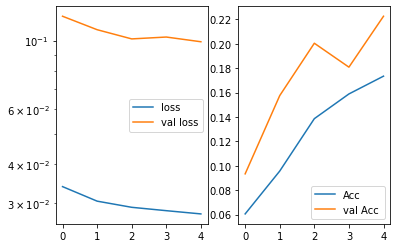

1273/1273 [==============================] - 58s 45ms/step - loss: 0.0276 - accuracy: 0.1734 - val_loss: 0.0992 - val_accuracy: 0.2225


In [ ]:

#Custom Model Architecture inspired by Allred at al. 2021

#Get input sizes
m, L, depth = X_train.shape
input_shape = (L, depth)

#-- parameters of the architecture
l2_rate = 1.e-6
dropout_rate = 0.10
nbclasses = 10

X_input = tf.keras.Input(input_shape)

X = X_input

X = Conv1D(filters = 32, kernel_size = 3, strides = 1, padding = "same", dilation_rate = 1, kernel_regularizer = l2(1.e-6), kernel_initializer = "he_normal")(X)
#X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "same", dilation_rate = 2, kernel_regularizer = l2(1.e-6), kernel_initializer = "he_normal")(X)
#X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
#X = AveragePooling1D(pool_size=2)(X)
X = Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = "same", dilation_rate = 4, kernel_regularizer = l2(1.e-6), kernel_initializer = "he_normal")(X)
#X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = Flatten()(X)
X = Dense(units = 512, kernel_initializer="he_normal", kernel_regularizer=l2(1.e-6))(X)
#X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
out = Dense(nbclasses, activation = "softmax", kernel_initializer="he_normal", kernel_regularizer=l2(1.e-6))(X)

model = tf.keras.Model(inputs = X_input, outputs = out, name = "Custom_Temporal_CNN")


#Define Class Weights
from sklearn.utils import class_weight

class_weights =  class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)

class_weights = {0: 0.0001,
                 1: 8.156186612576064,
                 2: 3.5251315020455873,
                 3: 30.983732876712327,
                 4: 0.07975888744407467,
                 5: 0.05826879417778994,
                 6: 0.0388306490552271,
                 7: 0.0370967576599387,
                 8: 4.064353099730458,
                 9: 13.428200371057514}


###
# Define Model Variables
###

# Model variables
n_epochs = 5
batch_size = 256
lr = 0.0001 #recommended in Allred et al., 2021
beta_1 = 0.9 #not used, but can be used to modify optimizer LR
beta_2 = 0.999
decay = 0.0
	
#Model Optimizer
#opt = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, decay=decay)
opt = tf.keras.optimizers.Adam(lr=lr)

# Compile Model
model.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["accuracy"])
	
# Model callbacks
checkpoint = ModelCheckpoint(out_model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')


#Plot Loss and Accuracy Callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.f1 = []
        self.val_f1 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1.append(logs.get('accuracy'))
        self.val_f1.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val loss")
        ax1.legend()
        
        ax2.plot(self.x, self.f1, label="Acc")
        ax2.plot(self.x, self.val_f1, label="val Acc ")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

callback_list = [plot_losses]
		

start_train_time = time.time()

hist = model.fit(x = X_train, y = y_train_one_hot, epochs = n_epochs,
                 batch_size = batch_size, shuffle=True,
                 validation_data=(X_val, y_val_one_hot),verbose=1, 
                 class_weight = class_weights, callbacks = [plot_losses])

train_time = round(time.time()-start_train_time, 2)





# Save/Load the trained model
Export the trained model to TensorFlow SavedModel format in your cloud storage bucket. The Cloud Platform storage browser is useful for checking on these saved models.

Call model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x. However, models can be saved in HDF5 format. More details on saving entire models in the two file formats is described below.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

*Custom objects (e.g. subclassed models or layers) require special attention when saving and loading. See the Saving custom objects section below

In [ ]:
# Save model to google cloud storage
MODEL_DIR = 'gs://' + 'landsat-csv-bucket' + '/demo_pixel_model'
model.save(MODEL_DIR, save_format='tf')

# Load trained model from google cloud storage

INFO:tensorflow:Assets written to: gs://landsat-csv-bucket/demo_pixel_model/assets


# EEification

EEIfication prepares the model for hosting on [Google AI Platform](https://cloud.google.com/ai-platform).  Learn more about EEification from [this doc](https://developers.google.com/earth-engine/tensorflow#interacting-with-models-hosted-on-ai-platform).  First, get (and SET) input and output names of the nodes.  **CHANGE THE OUTPUT NAME TO SOMETHING THAT MAKES SENSE FOR YOUR MODEL!**  Keep the input name of 'array', which is how you'll pass data into the model (as an array image).

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "output"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_1:0": "array"}'
'{"StatefulPartitionedCall:0": "output"}'


# Run the EEifier

The actual EEification is handled by the `earthengine model prepare` command.  Note that you will need to set your Cloud Project prior to running the command.

In [ ]:

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = 'gs://' + 'landsat-csv-bucket' + '/eeified_pixel_model'

# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Successfully saved project id
Success: model at 'gs://landsat-csv-bucket/eeified_pixel_model' is ready to be hosted in AI Platform.


# Deploy and host the EEified model on AI Platform

Now there is another TensorFlow `SavedModel` stored in `EEIFIED_DIR` ready for hosting by AI Platform.  Do that from the `gcloud` command line tool, installed in the Colab runtime by default.  Be sure to specify a regional model with the `REGION` parameter.  Note that the `MODEL_NAME` must be unique.  If you already have a model by that name, either name a new model or a new version of the old model.  The [Cloud Console AI Platform models page](https://console.cloud.google.com/ai-platform/models) is useful for monitoring your models.

**If you change anything about the trained model, you'll need to re-EEify it and create a new version!**

In [ ]:

PROJECT = 'pacific-engine-346519'
MODEL_NAME = 'pixel_demo_model_may2022_test1'
VERSION_NAME = 'v0'

# This is a good region for hosting AI models.
REGION = 'us-central1'

!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.3 \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/pacific-engine-346519/models/pixel_demo_model_may2022_test1].


To take a quick anonymous survey, run:
  $ gcloud survey

Using endpoint [https://us-central1-ml.googleapis.com/]


# Connect to the hosted model from Earth Engine

1. Generate the input imagery.  This should be done in exactly the same way as the training data were generated.  See [this example notebook](http://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb) for details.
2. Connect to the hosted model.
3. Use the model to make predictions.
4. Display the results.

Note that it takes the model a couple minutes to spin up and make predictions.

In [ ]:


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)


#Cloud Mask: https://gis.stackexchange.com/questions/274048/apply-cloud-mask-to-landsat-imagery-in-google-earth-engine-python-api
def getQABits(image, start, end, mascara): 
    # Compute the bits we need to extract.
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
    # Return a single band image of the extracted QA bits, giving the     band a new name.
    return image.select([0], [mascara]).bitwiseAnd(pattern).rightShift(start)


#Saturated band Mask: https://gis.stackexchange.com/questions/363929/how-to-apply-a-bitmask-for-radiometric-saturation-qa-in-a-image-collection-eart
def bitwiseExtract(value, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return value.rightShift(fromBit).bitwiseAnd(mask)


#Function to mask out cloudy and saturated pixels and harmonize between Landsat 5/7/8 imagery 
def maskQuality(image):
    # Select the QA band.
    QA = image.select('QA_PIXEL')
    # Get the internal_cloud_algorithm_flag bit.
    sombra = getQABits(QA,3,3,'cloud_shadow')
    nubes = getQABits(QA,5,5,'cloud')
    #  var cloud_confidence = getQABits(QA,6,7,  'cloud_confidence')
    cirrus_detected = getQABits(QA,9,9,'cirrus_detected')
    #var cirrus_detected2 = getQABits(QA,8,8,  'cirrus_detected2')
    #Return an image masking out cloudy areas.
    QA_radsat = image.select('QA_RADSAT')
    saturated = bitwiseExtract(QA_radsat, 1, 7)

    #Apply the scaling factors to the appropriate bands.
    def getFactorImg(factorNames):
      factorList = image.toDictionary().select(factorNames).values()
      return ee.Image.constant(factorList)

    scaleImg = getFactorImg(['REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])

    offsetImg = getFactorImg(['REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
    
    scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg)

    #Replace original bands with scaled bands and apply masks.
    return image.addBands(scaled, None, True).updateMask(sombra.eq(0)).updateMask(nubes.eq(0).updateMask(cirrus_detected.eq(0).updateMask(saturated.eq(0))))


# Selects and renames bands of interest for Landsat OLI.
def renameOli(img):
  return img.select(
    ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])


# Selects and renames bands of interest for TM/ETM+.
def renameEtm(img):
  return img.select(
    ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])


# Adding a NDVI band
def addNDVI(image):
  ndvi = image.normalizedDifference(['NIR', 'Red']).rename('NDVI')
  return image.addBands([ndvi])


def mapDates(image):
  date = ee.Date(image.get('system:time_start')).format("YYYY-MM-dd")
  return image.addBands([date])

# Prepares (renames) OLI images.
def prepOli(img):
  img = renameOli(img)
  return img


# Prepares (renames) TM/ETM+ images.
def prepEtm(img):
  orig = img
  img = renameEtm(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()))


# Selects and renames bands of interest for TM/ETM+.
def renameImageBands_TM(img, year, season):
  return img.select(
      ['Blue_median', 'Green_median', 'Red_median', 'NIR_median', 
       'SWIR1_median', 'SWIR2_median', 'NDVI_median'],
      ['Blue'+str(season)+str(year), 'Green'+str(season)+str(year), 'Red'+str(season)+str(year), 'NIR'+str(season)+str(year),
       'SWIR1'+str(season)+str(year), 'SWIR2'+str(season)+str(year), 'NDVI'+str(season)+str(year)])

# Selects and renames bands of interest for TM/ETM+.
def renameImageBands_ETMOLI(img, year, season):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 
       'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue'+str(season)+str(year), 'Green'+str(season)+str(year), 'Red'+str(season)+str(year), 'NIR'+str(season)+str(year),
       'SWIR1'+str(season)+str(year), 'SWIR2'+str(season)+str(year), 'NDVI'+str(season)+str(year)])




#Load sample points from Denver, CO area (~500 points)
pts = ee.FeatureCollection('users/lakex055/spurge_landcover_testpoints_denver_small')

#Sample points given a year, here we want points sampled from three years of Landsat imagery centered on 2019 

##########
## 2018 ##
##########

etmColMarchApril2018 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2018-03-01', '2018-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMarchApril2018 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2018-03-01', '2018-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MarchApril2018 = ee.ImageCollection([etmColMarchApril2018, oliColMarchApril2018])

etmColMarchApril2018 = MarchApril2018.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_1(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue_median_1', 'Green_median_1', 'Red_median_1', 'NIR_median_1','SWIR1_median_1', 'SWIR2_median_1', 'NDVI_median_1'])

etmColMarchApril2018 = renameEtm_median_1(etmColMarchApril2018)

etmColMayJune2018 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2018-05-01', '2018-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMayJune2018 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2018-05-01', '2018-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MayJune2018 = ee.ImageCollection([etmColMayJune2018, oliColMayJune2018])

etmColMayJune2018 = MayJune2018.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_2(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue_median_2', 'Green_median_2', 'Red_median_2', 'NIR_median_2','SWIR1_median_2', 'SWIR2_median_2', 'NDVI_median_2'])

etmColMayJune2018 = renameEtm_median_2(etmColMayJune2018)

etmColJulyAug2018 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2018-07-01', '2018-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median') \

oliColJulyAug2018 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2018-07-01', '2018-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

JulyAug2018 = ee.ImageCollection([etmColJulyAug2018, oliColJulyAug2018])

etmColJulyAug2018 = JulyAug2018.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_3(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue_median_3', 'Green_median_3', 'Red_median_3', 'NIR_median_3','SWIR1_median_3', 'SWIR2_median_3',  'NDVI_median_3'])

etmColJulyAug2018 = renameEtm_median_3(etmColJulyAug2018)





##########
## 2019 ##
##########

etmColMarchApril2019 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2019-03-01', '2019-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMarchApril2019 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2019-03-01', '2019-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MarchApril2019 = ee.ImageCollection([etmColMarchApril2019, oliColMarchApril2019])

etmColMarchApril2019 = MarchApril2019.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_4(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue_median_4', 'Green_median_4', 'Red_median_4', 'NIR_median_4','SWIR1_median_4', 'SWIR2_median_4', 'NDVI_median_4'])

etmColMarchApril2019 = renameEtm_median_4(etmColMarchApril2019)

etmColMayJune2019 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2019-05-01', '2019-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMayJune2019 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2019-05-01', '2019-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MayJune2019 = ee.ImageCollection([etmColMayJune2019, oliColMayJune2019])

etmColMayJune2019 = MayJune2019.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_5(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median',  'NDVI_median_median'],
      ['Blue_median_5', 'Green_median_5', 'Red_median_5', 'NIR_median_5','SWIR1_median_5', 'SWIR2_median_5',  'NDVI_median_5'])

etmColMayJune2019 = renameEtm_median_5(etmColMayJune2019)

etmColJulyAug2019 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2019-07-01', '2019-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median') \

oliColJulyAug2019 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2019-07-01', '2019-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

JulyAug2019 = ee.ImageCollection([etmColJulyAug2019, oliColJulyAug2019])

etmColJulyAug2019 = JulyAug2019.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_6(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median',  'NDVI_median_median'],
      ['Blue_median_6', 'Green_median_6', 'Red_median_6', 'NIR_median_6','SWIR1_median_6', 'SWIR2_median_6', 'NDVI_median_6'])

etmColJulyAug2019 = renameEtm_median_6(etmColJulyAug2019)


##########
## 2020 ##
##########

etmColMarchApril2020 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2020-03-01', '2020-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMarchApril2020 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2020-03-01', '2020-04-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MarchApril2020 = ee.ImageCollection([etmColMarchApril2020, oliColMarchApril2020])

etmColMarchApril2020 = MarchApril2020.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_7(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median',  'NDVI_median_median'],
      ['Blue_median_7', 'Green_median_7', 'Red_median_7', 'NIR_median_7','SWIR1_median_7', 'SWIR2_median_7', 'NDVI_median_7'])

etmColMarchApril2020 = renameEtm_median_7(etmColMarchApril2020)

etmColMayJune2020 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2020-05-01', '2020-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median')

oliColMayJune2020 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2020-05-01', '2020-06-30') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

MayJune2020 = ee.ImageCollection([etmColMayJune2020, oliColMayJune2020])

etmColMayJune2020 = MayJune2020.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_8(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median',  'NDVI_median_median'],
      ['Blue_median_8', 'Green_median_8', 'Red_median_8', 'NIR_median_8','SWIR1_median_8', 'SWIR2_median_8', 'NDVI_median_8'])

etmColMayJune2020 = renameEtm_median_8(etmColMayJune2020)

etmColJulyAug2020 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
  .filterDate('2020-07-01', '2020-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepEtm) \
  .map(addNDVI) \
  .reduce('median') \

oliColJulyAug2020 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2020-07-01', '2020-08-31') \
  .filterBounds(pts) \
  .map(maskQuality) \
  .map(prepOli) \
  .map(addNDVI) \
  .reduce('median')

JulyAug2020 = ee.ImageCollection([etmColJulyAug2020, oliColJulyAug2020])

etmColJulyAug2020 = JulyAug2020.reduce('median')

# Selects and renames bands of interest for TM/ETM+.
def renameEtm_median_9(img):
  return img.select(
      ['Blue_median_median', 'Green_median_median', 'Red_median_median', 'NIR_median_median', 'SWIR1_median_median', 'SWIR2_median_median', 'NDVI_median_median'],
      ['Blue_median_9', 'Green_median_9', 'Red_median_9', 'NIR_median_9','SWIR1_median_9', 'SWIR2_median_9',  'NDVI_median_9'])

etmColJulyAug2020 = renameEtm_median_9(etmColJulyAug2020)

#Combine images to one stack
combinedImages = etmColMarchApril2018.addBands(etmColMayJune2018) \
  .addBands(etmColJulyAug2018) \
  .addBands(etmColMarchApril2019) \
  .addBands(etmColMayJune2019) \
  .addBands(etmColJulyAug2019) \
  .addBands(etmColMarchApril2020) \
  .addBands(etmColMayJune2020) \
  .addBands(etmColJulyAug2020) \


#combinedImages.getInfo()

# Get a map ID for display in folium.
rgb_vis = {'bands': ['Red_median_2', 'Green_median_2', 'Blue_median_2'], 'min': 0, 'max': 0.3, 'format': 'png'}
mapid = combinedImages.getMapId(rgb_vis)

# Turn into an array image for input to the model.
array_image = combinedImages.float().toArray()


#---- Normalizing the data per band (Do we want to normalize across years or within one year?)
minMaxVal_file = '.'.join(out_model_file.split('.')[0:-1])
minMaxVal_file = minMaxVal_file + '_minMax.txt'

if not os.path.exists(minMaxVal_file): 
  min_per, max_per = readingsits.computingMinMax(X_train) #compute 98% min/max (per = 2) on bands
  readingsits.save_minMaxVal(minMaxVal_file, min_per, max_per)
else:
  min_per, max_per = readingsits.read_minMaxVal(minMaxVal_file)





# Point to the model hosted on AI Platform.  If you specified a region other
# than the default (us-central1) at model creation, specify it here.
model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    # Can be anything, but don't make it too big.
    inputTileSize=[8, 8],
    # Keep this the same as your training data.
    proj=ee.Projection('EPSG:4326').atScale(30),
    fixInputProj=True,
    # Note the names here need to match what you specified in the
    # output dictionary you passed to the EEifier.
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

inv_category_dict = {1:"Open Water", 2:"Developed", 3:"Barren", 4:"Forest", 5:"Shrub", 6:"Grassland/Herbaceous", 7:"Pasture/CultivatedCrops", 8:"EmergentHerbWetlands", 9:"LeafySpurge"} #define classes for prediction
class_names = [inv_category_dict[i] for i in np.arange(1, 10)]

import folium
print(folium.__version__)

# model.predictImage outputs a one dimensional array image that
# packs the output nodes of your model into an array.  These
# are class probabilities that you need to unpack into a 
# multiband image with arrayFlatten().  If you want class
# labels, use arrayArgmax() as follows.
predictions = model.predictImage(array_image)
probabilities = predictions.arrayFlatten([class_names])
label = predictions.arrayArgmax().arrayGet([0]).rename('label')


probabilities.getInfo()

# Get map IDs for display in folium.
probability_vis = {
    'bands': ["Open Water", "Developed", "Barren"], 'max': .5, 'format': 'png'
}
label_vis = {
    'palette': ['red', 'green', 'blue'], 'min': 0, 'max': 2, 'format': 'png'
}
probability_mapid = probabilities.getMapId(probability_vis)
label_mapid = label.getMapId(label_vis)

# Visualize the input imagery and the predictions.
map = folium.Map(location=[37.6413, -122.2582], zoom_start=11)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
folium.TileLayer(
  tiles=label_mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='predicted label',
).add_to(map)
folium.TileLayer(
  tiles=probability_mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='probability',
).add_to(map)
map.add_child(folium.LayerControl())
map

{'attempt': 1,
 'creation_timestamp_ms': 1654026473124,
 'description': 'clipped area',
 'error_message': 'Export too large: specified 892227573612 pixels (max: 100000000). Specify higher maxPixels value if you intend to export a large area.',
 'id': 'VEXJLYBH2ZLMYOI7FFL2LROU',
 'name': 'projects/earthengine-legacy/operations/VEXJLYBH2ZLMYOI7FFL2LROU',
 'start_timestamp_ms': 1654026485640,
 'state': 'FAILED',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1654026487129}

# Evaluate Model Performance

In [ ]:


"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
y_true and y_pred are the ground truth and prediction, converted to vector with np.flatten()
#Example Run
y_pred = model.predict(X_val) #predict model on validation dataset
y_pred = np.argmax(y_pred, axis=-1) #class with highest predicted probability is assigned to pixel
y_pred_flat = y_pred.flatten() #flatten prediction to vector
y_pred_flat = y_pred_flat.astype(int)
y_val = Y_val.astype(int) #withheld validation dataset   
y_val_flat = y_val.flatten()
inv_category_dict = {1:"Vegetation", 2:"Buildings", 3:"Roads", 4:"Water", 5:"Agriculture", 6:"Leafy Spurge"} #define classes for prediction
class_names = [inv_category_dict[i] for i in np.arange(1, 7)]
# run function and save plot of normalized confusion matrix
plot_confusion_matrix(
    y_val_flat,
    y_pred_flat,
    classes=class_names,
    test_name=model_name,
    normalize=True,
    save_fig=True
)
"""



print(X_train.shape, y_train_one_hot.shape, X_val.shape, y_val_one_hot.shape, X_test.shape, y_test_one_hot.shape)


#Example Run
y_pred = model.predict(X_test) #predict model on validation dataset
y_pred = np.argmax(y_pred, axis=-1) #class with highest predicted probability is assigned to pixel
y_pred_flat = y_pred.flatten() #flatten prediction to vector
y_pred_flat = y_pred_flat.astype(int)
y_val = y_test.astype(int) #withheld validation dataset   
y_val_flat = y_val.flatten()
inv_category_dict = {1:"Open Water", 2:"Developed", 3:"Barren", 4:"Forest", 5:"Shrub", 6:"Grassland/Herbaceous", 7:"Pasture/CultivatedCrops", 8:"EmergentHerbWetlands", 9:"LeafySpurge"} #define classes for prediction
class_names = [inv_category_dict[i] for i in np.arange(1, 10)]




import os
import sys
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.io import imread, imshow, imsave
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, jaccard_score, fbeta_score
from tensorflow.keras.models import load_model
from tabulate import tabulate

def plot_confusion_matrix(
        y_true,
        y_pred,
        classes,
        test_name,
        normalize=False,
        set_title=False,
        cmap=plt.cm.Blues,
):
    
    if set_title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # and save it to log file
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if normalize:
        im.set_clim(0., 1.)     # fixes missing '1.0' tick at top of colorbar
    cb = ax.figure.colorbar(im, ax=ax)
    if normalize:
        cb.set_ticks(np.arange(0., 1.2, 0.2))
        cb.set_ticklabels([f'{i/5:.1f}' for i in range(6)])
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title if set_title else None,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(cm)-0.5, -0.5)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(10)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.round(cm[i, j], 2) > 0.:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                ax.text(j, i, '–',
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax



# Interpret the confusion matrix
# https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
cm = plot_confusion_matrix(y_val_flat, y_pred_flat, classes=class_names, normalize = True, test_name="test") #how many samples per class have received their correct label (diagonal is recall/sensitivity value)


C = confusion_matrix(y_val_flat, y_pred_flat)
C / C.astype(np.float).sum(axis=1)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(y_val_flat, y_pred_flat)

accuracy = accuracy_score(y_val_flat, y_pred_flat) #overall model accuracy

print(precision, recall, fscore, support)


#calculate confusion matrix
class_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
c = multilabel_confusion_matrix(y_val_flat, y_pred_flat, labels = class_labels)
model_output_metrics = []
for i in range(len(class_labels)):
    tn=c[i, 0, 0]
    tp=c[i, 1, 1]
    fn=c[i, 1, 0]
    fp=c[i, 0, 1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    TPR_Sens_Recall = tp/(tp+fn)
    TNR_Spec = tn/(tn+fp)
    FPR = fp/(fp+tn)
    FNR = fn/(fn+tp)
    precision = tp/(tp+fp)
    jaccard = tp/(tp+fp+fn)
    beta = 0.5
    F05 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 1
    F1 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 2
    F2 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    outputs = [class_names[i], tp, tn, fp, fn, accuracy, TPR_Sens_Recall, TNR_Spec, FPR, FNR, precision, jaccard, F1]
    model_output_metrics.append(outputs)
print(tabulate(model_output_metrics, floatfmt=".2f", headers=["Class Name", "TP", "TN", "FP", "FN", "Accuracy", "TPR/Sens/Recall", "TNR/Spec", "FPR", "FNR", "Precision", "Jaccard", "F1"]))
    


# Model predictions with Earth Engine and Tensorflow AI (now Vertex AI) platform

#Run Temporal CNN from command line Python

(Not working currently)

In [ ]:

train_test_path = "/content/drive/My\ Drive/Invasives\ Research\ UMN/Spurge\ Remote\ Sensing\ Master/Leafy\ Spurge\ Demography/temporalCNN-master/example"

results_path = "/content/drive/My\ Drive/Invasives\ Research\ UMN/Spurge\ Remote\ Sensing\ Master/Leafy\ Spurge\ Demography/results"

!python3 '/content/drive/My Drive/Invasives Research UMN/Spurge Remote Sensing Master/Leafy Spurge Demography/temporalCNN-master/run_archi.py' '--sits_path' {train_test_path} '--res_path' {results_path} '--noarchi' 2
